In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
def load_data(filename):
    data = pd.read_csv(filename, skiprows=6, sep=' ', names=['index', 'x', 'y'], skipfooter=1, engine='python')
    return data.set_index('index')

def euclidean_distance(p1, p2):
    return round(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def calculate_distance_matrix(coords):
    size = coords.shape[0]
    matrix = np.zeros((size, size), dtype=int)
    coords_values = coords.values
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = euclidean_distance(coords_values[i], coords_values[j])
            else:
                matrix[i][j] = 0
    return matrix

def initialize_two_greedy_cycles(distance_matrix):
    n = len(distance_matrix)
    start1 = random.randint(0, n-1)
    nearest1 = np.argmin([distance_matrix[start1][i] if i != start1 else np.inf for i in range(n)])
    cycle1 = [start1, nearest1, start1]
    visited = set([start1, nearest1])

    distances_to_start1 = [distance_matrix[start1][i] for i in range(n)]
    start2 = np.argmax(distances_to_start1)
    while start2 in visited:
        distances_to_start1[start2] = -np.inf
        start2 = np.argmax(distances_to_start1)
        
    nearest2 = np.argmin([distance_matrix[start2][i] if i != start2 and i not in visited else np.inf for i in range(n)])
    cycle2 = [start2, nearest2, start2]
    visited.update([start2, nearest2])

    return cycle1, cycle2, visited

def calculate_cycle_length(cycle, distance_matrix):
    total_length = 0
    for i in range(len(cycle)):
        total_length += distance_matrix[cycle[i]][cycle[(i + 1) % len(cycle)]]
    return total_length

def plot_cycles(coords, cycle1, cycle2, title = 'Visualization of Two Cycles'):
    x_coords, y_coords = coords['x'].values, coords['y'].values

    plt.figure(figsize=(10, 8))
    
    # Plot cycle1
    x1 = [x_coords[i] for i in cycle1]
    y1 = [y_coords[i] for i in cycle1]
    plt.plot(x1, y1, 'ro-', label='Cycle 1')

    # Plot cycle2
    x2 = [x_coords[i] for i in cycle2]
    y2 = [y_coords[i] for i in cycle2]
    plt.plot(x2, y2, 'bo-', label='Cycle 2')

    plt.scatter(x_coords, y_coords, color='gray', zorder=3)
    
    for i in range(len(x_coords)):
        plt.annotate(str(i), (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



## Heurystyka z 2-żalem (2-regret)

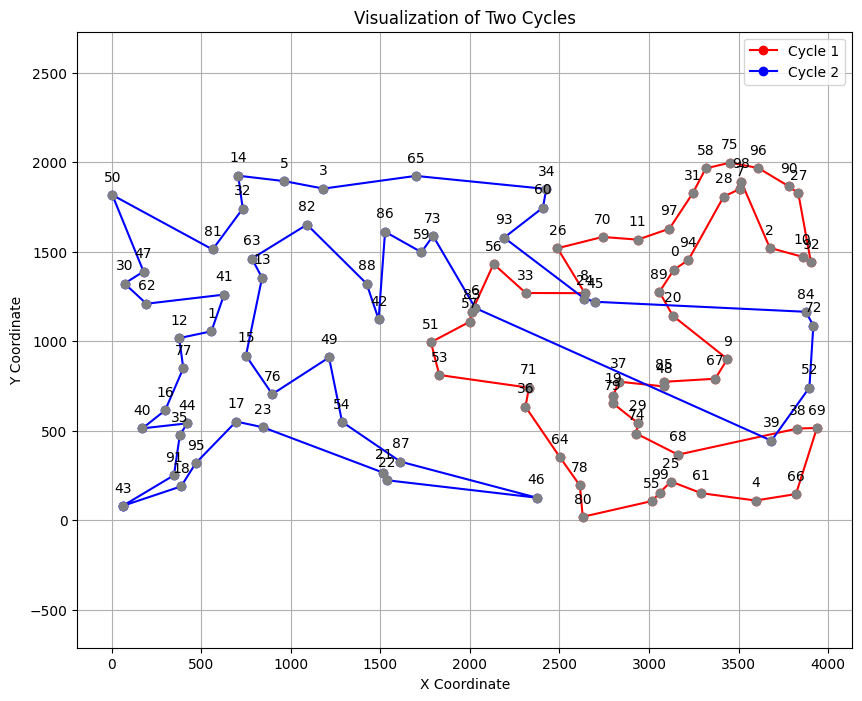

Cycle 1: [7, 28, 94, 0, 89, 20, 9, 67, 85, 48, 37, 19, 79, 29, 74, 68, 38, 69, 66, 4, 61, 25, 99, 55, 80, 78, 64, 36, 71, 53, 51, 57, 83, 56, 33, 8, 26, 70, 11, 97, 31, 58, 75, 96, 90, 27, 92, 10, 2, 98, 7] Length: 10713
Cycle 2: [43, 18, 95, 17, 23, 21, 22, 46, 87, 54, 49, 76, 15, 13, 63, 82, 88, 42, 86, 59, 73, 6, 39, 52, 72, 84, 45, 24, 93, 60, 34, 65, 3, 5, 14, 32, 81, 50, 47, 30, 62, 41, 1, 12, 77, 16, 40, 44, 35, 91, 43] Length: 18378
score: 29091


In [3]:
def insert_with_2_regret(cycle, visited, distance_matrix):
    insertions = []

    for vertex in range(len(distance_matrix)):
        if vertex not in visited:
            insertion_costs = []

            for position in range(1, len(cycle)):
                new_cycle = cycle[:position] + [vertex] + cycle[position:]
                cost_increase = calculate_cycle_length(new_cycle, distance_matrix) - calculate_cycle_length(cycle, distance_matrix)
                insertion_costs.append((cost_increase, position))

            if len(insertion_costs) >= 2:
                insertion_costs.sort()
                #print(insertion_costs)
                min_cost_1 = insertion_costs[0][0]
                min_cost_2 = insertion_costs[1][0]
                regret = min_cost_2 - min_cost_1
                weight = regret - 0.37*min_cost_1

                insertions.append((weight, vertex, insertion_costs[0][1]))

    insertions.sort(reverse=True)
    # print(insertions)

    if insertions:
        highest_regret = insertions[0]
        best_vertex = highest_regret[1]
        best_position = highest_regret[2]
        cycle.insert(best_position, best_vertex)
        visited.add(best_vertex)

    return cycle

def expand_cycles_with_2_regret(coords, distance_matrix):
    cycle1, cycle2, visited = initialize_two_greedy_cycles(distance_matrix)
    total_vertices = len(coords)

    while len(visited) < total_vertices:
        if len(visited) < total_vertices:
            cycle1 = insert_with_2_regret(cycle1, visited, distance_matrix)
        if len(visited) < total_vertices:
            cycle2 = insert_with_2_regret(cycle2, visited, distance_matrix)

    return cycle1, cycle2, calculate_cycle_length(cycle1, distance_matrix), calculate_cycle_length(cycle2, distance_matrix)

filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'
coords_A = load_data(filename_kroA100)
coords_B = load_data(filename_kroB100)
distance_matrix_A = calculate_distance_matrix(coords_A)
distance_matrix_B = calculate_distance_matrix(coords_B)
cycle1, cycle2, length1, length2 = expand_cycles_with_2_regret(coords_B, distance_matrix_B)
plot_cycles(coords_B, cycle1, cycle2)
print("Cycle 1:", cycle1, "Length:", length1)
print("Cycle 2:", cycle2 , "Length:", length2)
print("score:", length1 + length2)

# Eksperyment obliczeniowy

In [4]:
def run_2_regret_experiments(filename, num_runs=100):
    coords = load_data(filename)
    distance_matrix = calculate_distance_matrix(coords)

    regret_lengths = []
    best_regret_cycle1, best_regret_cycle2 = None, None
    min_regret_length = float('inf')

    for _ in range(num_runs):
        # 2-Regret Heuristic
        cycle1, cycle2, length1, length2 = expand_cycles_with_2_regret(coords, distance_matrix)
        length = length1 + length2
        regret_lengths.append(length)
        if length < min_regret_length:
            min_regret_length = length
            best_regret_cycle1, best_regret_cycle2 = cycle1, cycle2

    regret_stats = (np.mean(regret_lengths), np.min(regret_lengths), np.max(regret_lengths), best_regret_cycle1, best_regret_cycle2, min_regret_length)
    return regret_stats

# Running 2-Regret experiments
filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'

regret_stats_A = run_2_regret_experiments(filename_kroA100)
regret_stats_B = run_2_regret_experiments(filename_kroB100)

# Prepare results table
results = {
    'Instance': ['kroA100', 'kroB100'],
    'Method': ['2-Regret', '2-Regret'],
    'Mean': [regret_stats_A[0], regret_stats_B[0]],
    'Min': [regret_stats_A[1], regret_stats_B[1]],
    'Max': [regret_stats_A[2], regret_stats_B[2]]
}

results_df = pd.DataFrame(results)

# Save best cycles for plotting
best_cycles = {
    'kroA100_2Regret': (regret_stats_A[3], regret_stats_A[4], regret_stats_A[5]),
    'kroB100_2Regret': (regret_stats_B[3], regret_stats_B[4], regret_stats_B[5])
}


results_df = pd.DataFrame(results)
results_df

,Instance,Method,Mean,Min,Max
0,kroA100,2-Regret,26656.55,22914,29510
1,kroB100,2-Regret,27688.91,24172,29378


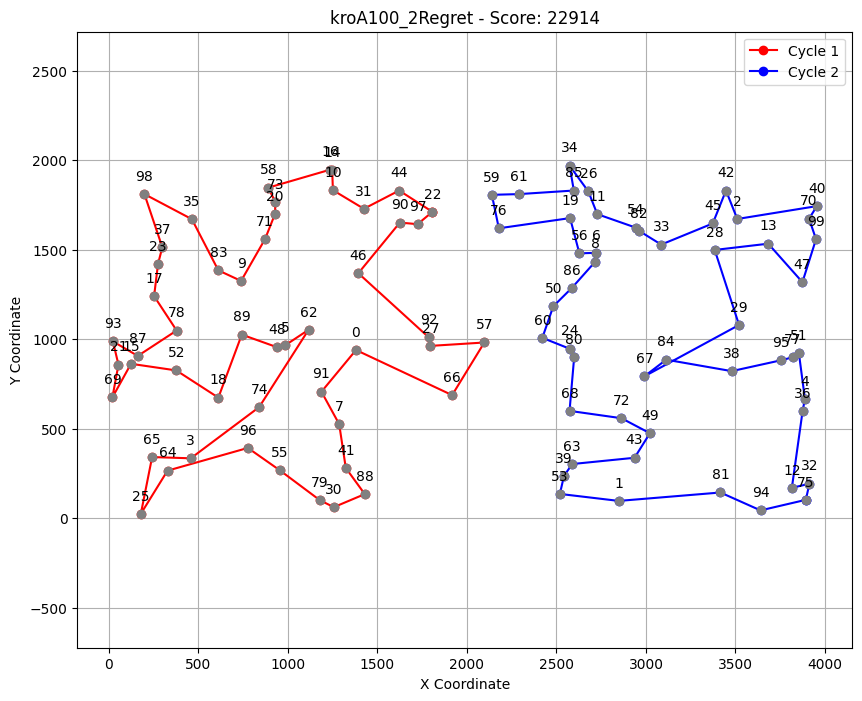

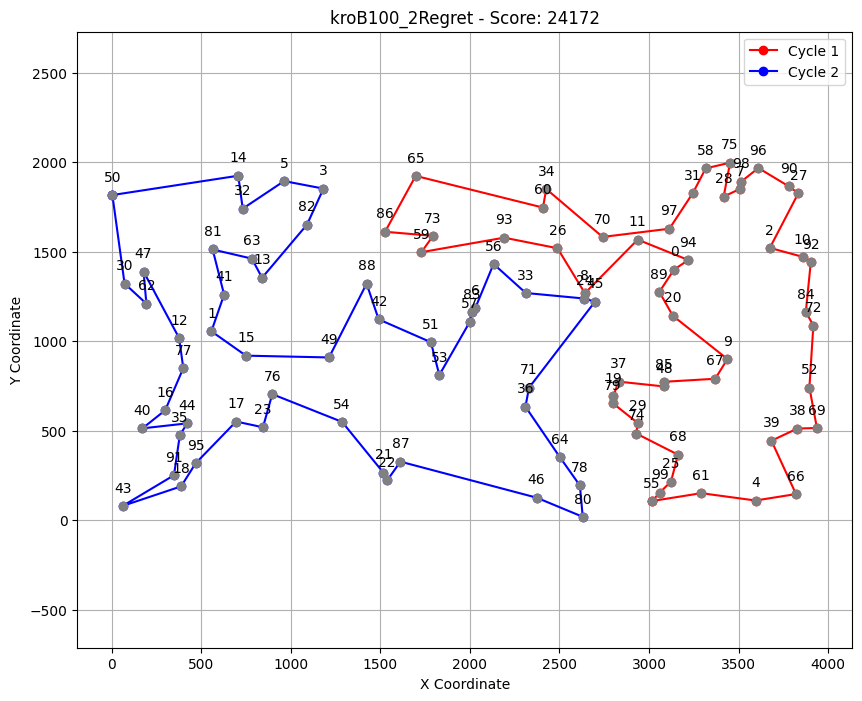

In [5]:
# Plottting best cycles
for instance, cycles in best_cycles.items():
    cycle1, cycle2, score = cycles
    coords = load_data(f'{instance.split("_")[0]}.tsp')
    plot_cycles(coords, cycle1, cycle2, title=f'{instance} - Score: {score}')
    

# Funkcje pomocnicze do local search

In [4]:
def create_random_cycles(distance_matrix):
    num_vertices = len(distance_matrix)
    vertices = list(range(num_vertices))
    random.shuffle(vertices)
    mid = num_vertices // 2
    
    cycle1 = vertices[:mid] + [vertices[0]]
    cycle2 = vertices[mid:] + [vertices[mid]]
    
    return cycle1, cycle2

def calculate_score(cycle1, cycle2, distance_matrix):
    length1 = calculate_cycle_length(cycle1, distance_matrix)
    length2 = calculate_cycle_length(cycle2, distance_matrix)
    return length1 + length2

def swap_between_cycles(cycle1, cycle2, idx1, idx2):
    new_cycle1 = cycle1[:]
    new_cycle2 = cycle2[:]
    new_cycle1[idx1], new_cycle2[idx2] = new_cycle2[idx2], new_cycle1[idx1]
    return new_cycle1, new_cycle2

def delta_swap_vertices_between_cycles(cycle1, cycle2, idx1, idx2, distance_matrix):
    vertex1 = cycle1[idx1]
    vertex2 = cycle2[idx2]

    prev_vertex1 = cycle1[idx1 - 1]
    next_vertex1 = cycle1[(idx1 + 1) % len(cycle1)]
    prev_vertex2 = cycle2[idx2 - 1]
    next_vertex2 = cycle2[(idx2 + 1) % len(cycle2)]

    # Calculate the original distance
    original_distance = (distance_matrix[prev_vertex1][vertex1] + 
                         distance_matrix[vertex1][next_vertex1] + 
                         distance_matrix[prev_vertex2][vertex2] + 
                         distance_matrix[vertex2][next_vertex2])

    # Calculate the new distance
    new_distance = (distance_matrix[prev_vertex1][vertex2] + 
                    distance_matrix[vertex2][next_vertex1] + 
                    distance_matrix[prev_vertex2][vertex1] + 
                    distance_matrix[vertex1][next_vertex2])

    delta = new_distance - original_distance
    return delta

def swap_within_cycle(cycle, idx1, idx2):
    new_cycle = cycle[:]
    new_cycle[idx1], new_cycle[idx2] = new_cycle[idx2], new_cycle[idx1]
    return new_cycle

def delta_swap_vertices_within_cycle(cycle, idx1, idx2, distance_matrix):
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1

    prev_vertex1 = cycle[idx1 - 1]
    vertex1 = cycle[idx1]
    next_vertex1 = cycle[idx1 + 1]
    prev_vertex2 = cycle[idx2 - 1]
    vertex2 = cycle[idx2]
    next_vertex2 = cycle[idx2 + 1]

    # Calculate the original distance
    original_distance = (distance_matrix[prev_vertex1][vertex1] + 
                         distance_matrix[vertex1][next_vertex1] + 
                         distance_matrix[prev_vertex2][vertex2] + 
                         distance_matrix[vertex2][next_vertex2])

    # Calculate the new distance
    new_distance = (distance_matrix[prev_vertex1][vertex2] + 
                    distance_matrix[vertex2][next_vertex1] + 
                    distance_matrix[prev_vertex2][vertex1] + 
                    distance_matrix[vertex1][next_vertex2])

    delta = new_distance - original_distance
    return delta

def swap_edges_in_cycle(cycle, idx1, idx2):
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1
    new_cycle = cycle[:idx1+1] + cycle[idx1+1:idx2+1][::-1] + cycle[idx2+1:]
    return new_cycle

def delta_swap_edges_in_cycle(cycle, idx1, idx2, distance_matrix):
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1

    prev_vertex1 = cycle[idx1]
    next_vertex1 = cycle[idx1 + 1]
    prev_vertex2 = cycle[idx2]
    next_vertex2 = cycle[idx2 + 1]

    # Calculate the original distance
    original_distance = (distance_matrix[prev_vertex1][next_vertex1] + 
                         distance_matrix[prev_vertex2][next_vertex2])

    # Calculate the new distance
    new_distance = (distance_matrix[prev_vertex1][prev_vertex2] + 
                    distance_matrix[next_vertex1][next_vertex2])

    delta = new_distance - original_distance
    return delta

def generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix):
    possible_swaps = []

    for i in range(len(cycle1) - 1):
        for j in range(len(cycle2) - 1):
            new_cycle1, new_cycle2 = swap_between_cycles(cycle1, cycle2, i, j)
            score = calculate_score(new_cycle1, new_cycle2, distance_matrix)
            # delta = delta_swap_vertices_between_cycles(cycle1, cycle2, i, j, distance_matrix)
            possible_swaps.append((new_cycle1, new_cycle2, score))
    
    return possible_swaps

def generate_all_vertex_swaps_within_cycles(cycle1, cycle2, distance_matrix):
    possible_swaps = []

    # Swap within the first cycle
    for i in range(len(cycle1) - 1):
        for j in range(i + 1, len(cycle1) - 1):
            new_cycle1 = swap_within_cycle(cycle1, i, j)
            score = calculate_score(new_cycle1, cycle2, distance_matrix)
            # delta = delta_swap_vertices_within_cycle(cycle1, i, j, distance_matrix)
            possible_swaps.append((new_cycle1, cycle2, score))

    # Swap within the second cycle
    for i in range(len(cycle2) - 1):
        for j in range(i + 1, len(cycle2) - 1):
            new_cycle2 = swap_within_cycle(cycle2, i, j)
            score = calculate_score(cycle1, new_cycle2, distance_matrix)
            # delta = delta_swap_vertices_within_cycle(cycle2, i, j, distance_matrix)
            possible_swaps.append((cycle1, new_cycle2, score))
    
    return possible_swaps

def generate_all_edge_swaps_within_cycles(cycle1, cycle2, distance_matrix):
    possible_swaps = []

    # Swap edges within the first cycle
    for i in range(len(cycle1) - 1):
        for j in range(i + 1, len(cycle1) - 1):
            new_cycle1 = swap_edges_in_cycle(cycle1, i, j)
            score = calculate_score(new_cycle1, cycle2, distance_matrix)
            # delta = delta_swap_edges_in_cycle(cycle1, i, j, distance_matrix)
            possible_swaps.append((new_cycle1, cycle2, score))

    # Swap edges within the second cycle
    for i in range(len(cycle2) - 1):
        for j in range(i + 1, len(cycle2) - 1):
            new_cycle2 = swap_edges_in_cycle(cycle2, i, j)
            score = calculate_score(cycle1, new_cycle2, distance_matrix)
            # delta = delta_swap_edges_in_cycle(cycle2, i, j, distance_matrix)
            possible_swaps.append((cycle1, new_cycle2, score))
    
    return possible_swaps

def generate_all_moves(cycle1, cycle2, distance_matrix):
    possible_moves = []
    possible_moves.extend(generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_vertex_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_edge_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    return possible_moves

def generate_combined_moves_list_1(cycle1, cycle2, distance_matrix):
    possible_moves = []
    possible_moves.extend(generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_vertex_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    return possible_moves

def generate_combined_moves_list_2(cycle1, cycle2, distance_matrix):
    possible_moves = []
    possible_moves.extend(generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_edge_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    return possible_moves

def steepest_ascent_local_search(cycle1, cycle2, distance_matrix, move_list_generator):
    start_time = time.time()
    best_cycle1, best_cycle2 = cycle1, cycle2
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    while True:
        possible_moves = move_list_generator(best_cycle1, best_cycle2, distance_matrix)
        improved = False
        for new_cycle1, new_cycle2, score in possible_moves:
            if score < best_score:
                best_cycle1, best_cycle2 = new_cycle1, new_cycle2
                best_score = score
                improved = True
        
        if not improved:
            break
    
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    end_time = time.time()
    time_taken = end_time - start_time
    
    return best_cycle1, best_cycle2, best_score, time_taken

def greedy_local_search(cycle1, cycle2, distance_matrix, move_list_generator):
    start_time = time.time()
    
    best_cycle1, best_cycle2 = cycle1, cycle2
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    while True:
        possible_moves = move_list_generator(best_cycle1, best_cycle2, distance_matrix)
        # Randomly reverse the list
        if random.random() < 0.5:
            possible_moves.reverse()
        
        start_index = random.randint(0, len(possible_moves) - 1)
        improved = False
        
        for i in range(len(possible_moves)):
            index = (start_index + i) % len(possible_moves)
            new_cycle1, new_cycle2, score = possible_moves[index]
            if score < best_score:
                best_cycle1, best_cycle2 = new_cycle1, new_cycle2
                best_score = score
                improved = True
                break
        
        if not improved:
            break
        
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    end_time = time.time()
    time_taken = end_time - start_time
    
    return best_cycle1, best_cycle2, best_score, time_taken

def randomized_optimization(cycle1, cycle2, distance_matrix, time_limit):
    start_time = time.time()
    end_time = start_time + time_limit
    
    best_cycle1, best_cycle2 = cycle1, cycle2
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    
    while time.time() < end_time:
        possible_moves = generate_all_moves(best_cycle1, best_cycle2, distance_matrix)
        if not possible_moves:
            break
        random_move = random.choice(possible_moves)
        new_cycle1, new_cycle2, score = random_move
        
        if score < best_score:
            best_cycle1, best_cycle2 = new_cycle1, new_cycle2
            best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    
    time_taken = time.time() - start_time
    
    return best_cycle1, best_cycle2, best_score, time_taken



In [7]:
# just to test
cycle1, cycle2 = best_cycles['kroA100_2Regret'][:2]
distance_matrix = calculate_distance_matrix(load_data('kroA100.tsp'))
restults = greedy_local_search(cycle1, cycle2, distance_matrix, generate_combined_moves_list_1)
print(restults)

([22, 44, 31, 10, 14, 16, 58, 73, 20, 71, 9, 83, 35, 98, 37, 23, 17, 78, 87, 93, 21, 69, 15, 52, 18, 89, 48, 5, 62, 74, 3, 65, 25, 64, 96, 55, 79, 30, 88, 41, 7, 91, 0, 66, 57, 27, 92, 46, 90, 97, 22], [12, 94, 81, 1, 53, 39, 63, 43, 49, 72, 68, 80, 24, 60, 50, 86, 8, 6, 56, 19, 76, 59, 61, 34, 85, 26, 11, 54, 82, 33, 45, 42, 2, 40, 70, 99, 47, 13, 28, 29, 84, 67, 38, 95, 77, 51, 4, 36, 32, 75, 75], 22733, 0.43450403213500977)


In [8]:
# Running all experiments
data_kroA100 = load_data('kroA100.tsp')
data_kroB100 = load_data('kroB100.tsp')
distance_matrix_A = calculate_distance_matrix(data_kroA100)
distance_matrix_B = calculate_distance_matrix(data_kroB100)
kroA_best_cycle1, kroA_best_cycle2 = best_cycles['kroA100_2Regret'][:2]
kroB_best_cycle1, kroB_best_cycle2 = best_cycles['kroB100_2Regret'][:2]
A_random_cycle1, A_random_cycle2 = create_random_cycles(distance_matrix_A)
B_random_cycle1, B_random_cycle2 = create_random_cycles(distance_matrix_B)
num_runs = 100

# Function to run and collect stats, including best cycles
def run_and_collect_stats(cycle1, cycle2, distance_matrix, search_function, move_list_generator=None):
    scores = []
    best_cycle1, best_cycle2 = None, None
    best_score = float('inf')
    
    for _ in range(num_runs):
        if move_list_generator:
            new_cycle1, new_cycle2, score, _ = search_function(cycle1, cycle2, distance_matrix, move_list_generator)
        else:
            new_cycle1, new_cycle2, score, _ = search_function(cycle1, cycle2, distance_matrix, average_time)
        
        scores.append(score)
        if score < best_score:
            best_score = score
            best_cycle1, best_cycle2 = new_cycle1, new_cycle2
    
    return np.min(scores), np.max(scores), np.mean(scores), best_cycle1, best_cycle2

#Calculate average run time for greedy and steepest ascent
_, _, _, greedy_time = greedy_local_search(A_random_cycle1, A_random_cycle2, distance_matrix_A, generate_combined_moves_list_1)
_, _, _, steepest_time = steepest_ascent_local_search(A_random_cycle1, A_random_cycle2, distance_matrix_A, generate_combined_moves_list_1)
average_time = (greedy_time + steepest_time) / 2
results = []
best_cycles = {}

# Random, vertices, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(A_random_cycle1, A_random_cycle2, distance_matrix_A, greedy_local_search, generate_combined_moves_list_1)
results.append(["Random", "Vertices", "Greedy", min_score, max_score, mean_score])
best_cycles["Random_Vertices_Greedy_A"] = (best_cycle1, best_cycle2)
print("finished Random_Vertices_Greedy_A")

# Random, vertices, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(A_random_cycle1, A_random_cycle2, distance_matrix_A, steepest_ascent_local_search, generate_combined_moves_list_1)
results.append(["Random", "Vertices", "Steep", min_score, max_score, mean_score])
best_cycles["Random_Vertices_Steep_A"] = (best_cycle1, best_cycle2)
print("finished Random_Vertices_Steep_A")

# Random, edges, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(A_random_cycle1, A_random_cycle2, distance_matrix_A, greedy_local_search, generate_combined_moves_list_2)
results.append(["Random", "Edges", "Greedy", min_score, max_score, mean_score])
best_cycles["Random_Edges_Greedy_A"] = (best_cycle1, best_cycle2)
print("finished Random_Edges_Greedy_A")

# Random, edges, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(A_random_cycle1, A_random_cycle2, distance_matrix_A, steepest_ascent_local_search, generate_combined_moves_list_2)
results.append(["Random", "Edges", "Steep", min_score, max_score, mean_score])
best_cycles["Random_Edges_Steep_A"] = (best_cycle1, best_cycle2)
print("finished Random_Edges_Steep_A")

# Random, random search
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(A_random_cycle1, A_random_cycle2, distance_matrix_A, randomized_optimization)
results.append(["Random", "-", "Random search", min_score, max_score, mean_score])
best_cycles["Random_RandomSearch_A"] = (best_cycle1, best_cycle2)
print("finished Random_RandomSearch_A")

# 2-regret, vertices, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroA_best_cycle1, kroA_best_cycle2, distance_matrix_A, greedy_local_search, generate_combined_moves_list_1)
results.append(["2-regret", "Vertices", "Greedy", min_score, max_score, mean_score])
best_cycles["2Regret_Vertices_Greedy_A"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Vertices_Greedy_A")

# 2-regret, vertices, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroA_best_cycle1, kroA_best_cycle2, distance_matrix_A, steepest_ascent_local_search, generate_combined_moves_list_1)
results.append(["2-regret", "Vertices", "Steep", min_score, max_score, mean_score])
best_cycles["2Regret_Vertices_Steep_A"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Vertices_Steep_A")

# 2-regret, edges, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroA_best_cycle1, kroA_best_cycle2, distance_matrix_A, greedy_local_search, generate_combined_moves_list_2)
results.append(["2-regret", "Edges", "Greedy", min_score, max_score, mean_score])
best_cycles["2Regret_Edges_Greedy_A"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Edges_Greedy_A")

# 2-regret, edges, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroA_best_cycle1, kroA_best_cycle2, distance_matrix_A, steepest_ascent_local_search, generate_combined_moves_list_2)
results.append(["2-regret", "Edges", "Steep", min_score, max_score, mean_score])
best_cycles["2Regret_Edges_Steep_A"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Edges_Steep_A")

# 2-regret, random search
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroA_best_cycle1, kroA_best_cycle2, distance_matrix_A, randomized_optimization)
results.append(["2-regret", "-", "Random search", min_score, max_score, mean_score])
best_cycles["2Regret_RandomSearch_A"] = (best_cycle1, best_cycle2)
print("finished 2Regret_RandomSearch_A")

# Convert results to DataFrame and display
columns = ["Starting cycles", "Neighbourhood", "Method", "Min", "Max", "Mean"]
df_results_A = pd.DataFrame(results, columns=columns)
print("Results for kroA100.tsp:")
print(df_results_A)

# Repeat the same for kroB100.tsp
results = []

# Random, vertices, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(B_random_cycle1, B_random_cycle2, distance_matrix_B, greedy_local_search, generate_combined_moves_list_1)
results.append(["Random", "Vertices", "Greedy", min_score, max_score, mean_score])
best_cycles["Random_Vertices_Greedy_B"] = (best_cycle1, best_cycle2)
print("finished Random_Vertices_Greedy_B")

# Random, vertices, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(B_random_cycle1, B_random_cycle2, distance_matrix_B, steepest_ascent_local_search, generate_combined_moves_list_1)
results.append(["Random", "Vertices", "Steep", min_score, max_score, mean_score])
best_cycles["Random_Vertices_Steep_B"] = (best_cycle1, best_cycle2)
print("finished Random_Vertices_Steep_B")

# Random, edges, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(B_random_cycle1, B_random_cycle2, distance_matrix_B, greedy_local_search, generate_combined_moves_list_2)
results.append(["Random", "Edges", "Greedy", min_score, max_score, mean_score])
best_cycles["Random_Edges_Greedy_B"] = (best_cycle1, best_cycle2)
print("finished Random_Edges_Greedy_B")

# Random, edges, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(B_random_cycle1, B_random_cycle2, distance_matrix_B, steepest_ascent_local_search, generate_combined_moves_list_2)
results.append(["Random", "Edges", "Steep", min_score, max_score, mean_score])
best_cycles["Random_Edges_Steep_B"] = (best_cycle1, best_cycle2)
print("finished Random_Edges_Steep_B")

# Random, random search
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(B_random_cycle1, B_random_cycle2, distance_matrix_B, randomized_optimization)
results.append(["Random", "-", "Random search", min_score, max_score, mean_score])
best_cycles["Random_RandomSearch_B"] = (best_cycle1, best_cycle2)
print("finished Random_RandomSearch_B")

# 2-regret, vertices, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroB_best_cycle1, kroB_best_cycle2, distance_matrix_B, greedy_local_search, generate_combined_moves_list_1)
results.append(["2-regret", "Vertices", "Greedy", min_score, max_score, mean_score])
best_cycles["2Regret_Vertices_Greedy_B"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Vertices_Greedy_B")

# 2-regret, vertices, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroB_best_cycle1, kroB_best_cycle2, distance_matrix_B, steepest_ascent_local_search, generate_combined_moves_list_1)
results.append(["2-regret", "Vertices", "Steep", min_score, max_score, mean_score])
best_cycles["2Regret_Vertices_Steep_B"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Vertices_Steep_B")

# 2-regret, edges, greedy
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroB_best_cycle1, kroB_best_cycle2, distance_matrix_B, greedy_local_search, generate_combined_moves_list_2)
results.append(["2-regret", "Edges", "Greedy", min_score, max_score, mean_score])
best_cycles["2Regret_Edges_Greedy_B"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Edges_Greedy_B")

# 2-regret, edges, steep
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroB_best_cycle1, kroB_best_cycle2, distance_matrix_B, steepest_ascent_local_search, generate_combined_moves_list_2)
results.append(["2-regret", "Edges", "Steep", min_score, max_score, mean_score])
best_cycles["2Regret_Edges_Steep_B"] = (best_cycle1, best_cycle2)
print("finished 2Regret_Edges_Steep_B")

# 2-regret, random search
min_score, max_score, mean_score, best_cycle1, best_cycle2 = run_and_collect_stats(kroB_best_cycle1, kroB_best_cycle2, distance_matrix_B, randomized_optimization)
results.append(["2-regret", "-", "Random search", min_score, max_score, mean_score])
best_cycles["2Regret_RandomSearch_B"] = (best_cycle1, best_cycle2)
print("finished 2Regret_RandomSearch_B")

# Convert results to DataFrame and display
df_results_B = pd.DataFrame(results, columns=columns)
print("Results for kroB100.tsp:")
print(df_results_B)


finished Random_Vertices_Greedy_A
finished Random_Vertices_Steep_A
finished Random_Edges_Greedy_A
finished Random_Edges_Steep_A
finished Random_RandomSearch_A
finished 2Regret_Vertices_Greedy_A
finished 2Regret_Vertices_Steep_A
finished 2Regret_Edges_Greedy_A
finished 2Regret_Edges_Steep_A
finished 2Regret_RandomSearch_A
Results for kroA100.tsp:
  Starting cycles Neighbourhood         Method     Min     Max       Mean
0          Random      Vertices         Greedy   33060   54400   42931.26
1          Random      Vertices          Steep   48429   48429   48429.00
2          Random         Edges         Greedy   26053   31782   28399.49
3          Random         Edges          Steep   28470   28470   28470.00
4          Random             -  Random search  108541  133853  118674.58
5        2-regret      Vertices         Greedy   22733   22733   22733.00
6        2-regret      Vertices          Steep   22733   22733   22733.00
7        2-regret         Edges         Greedy   22733   227

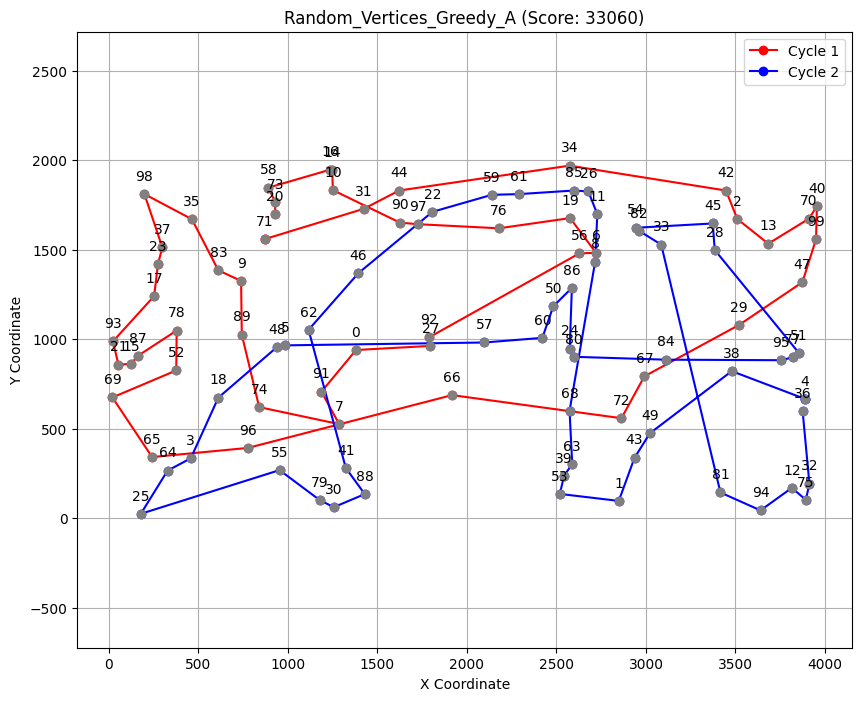

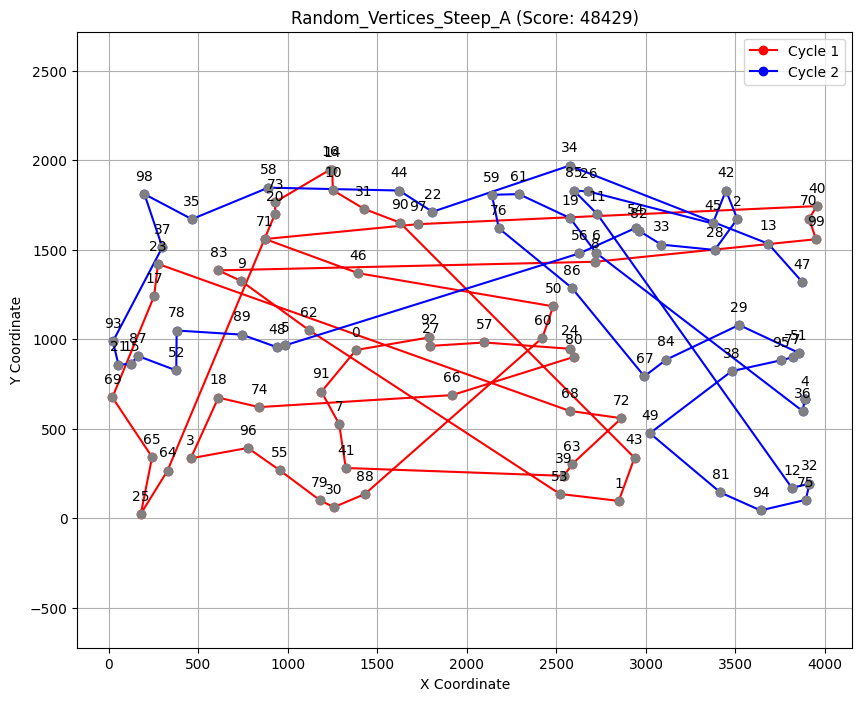

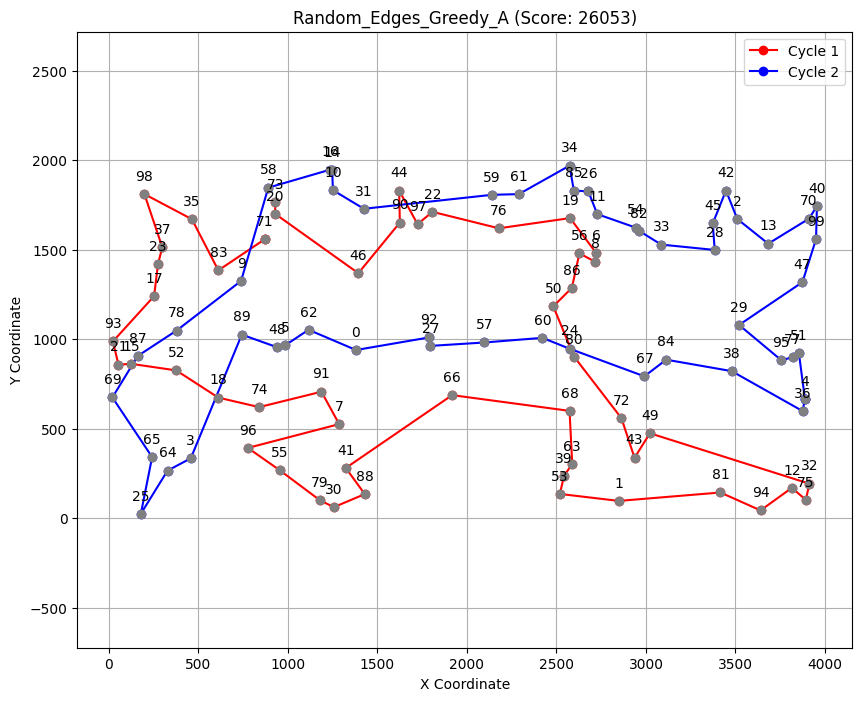

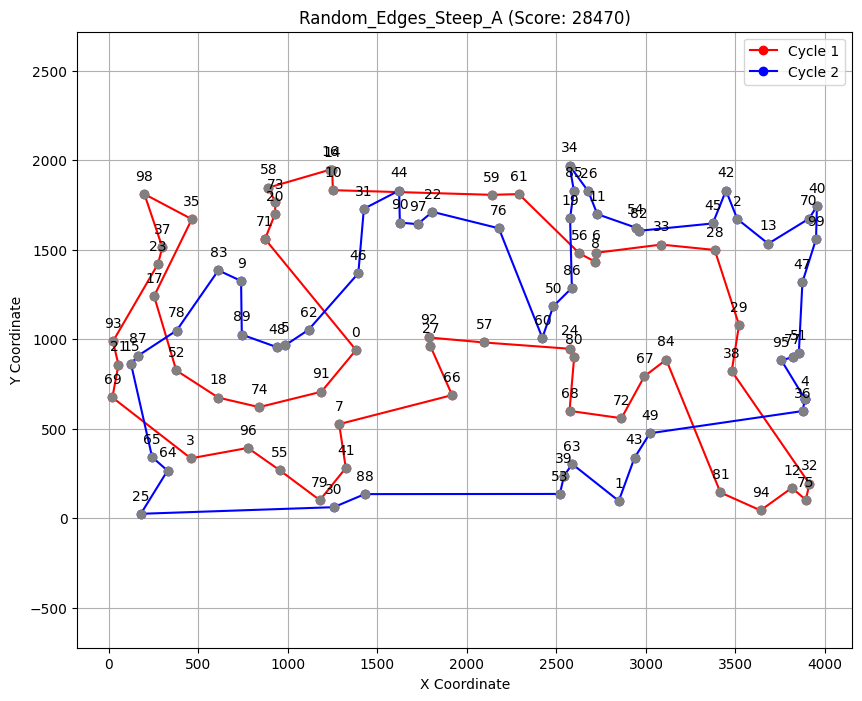

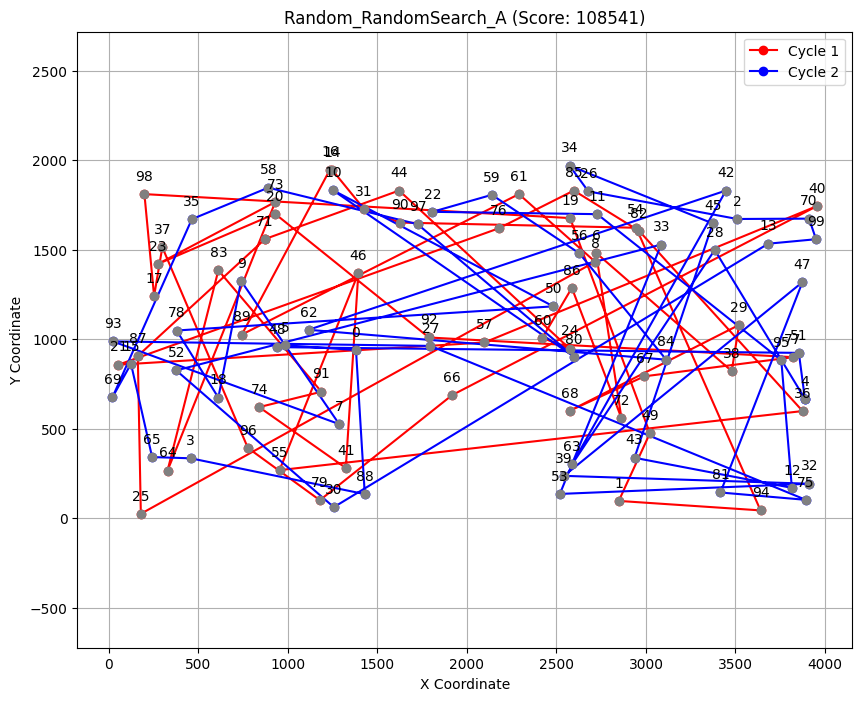

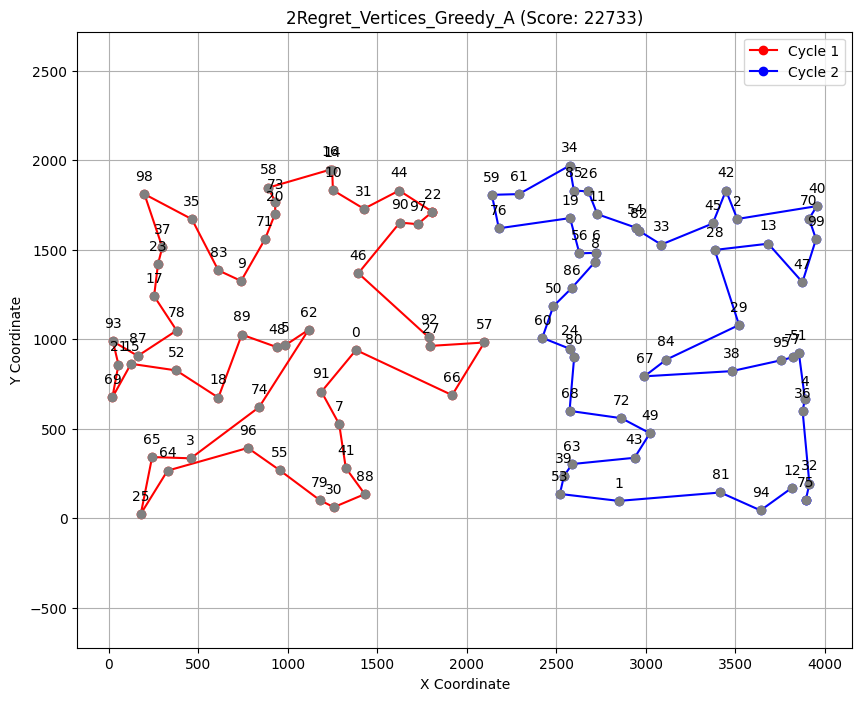

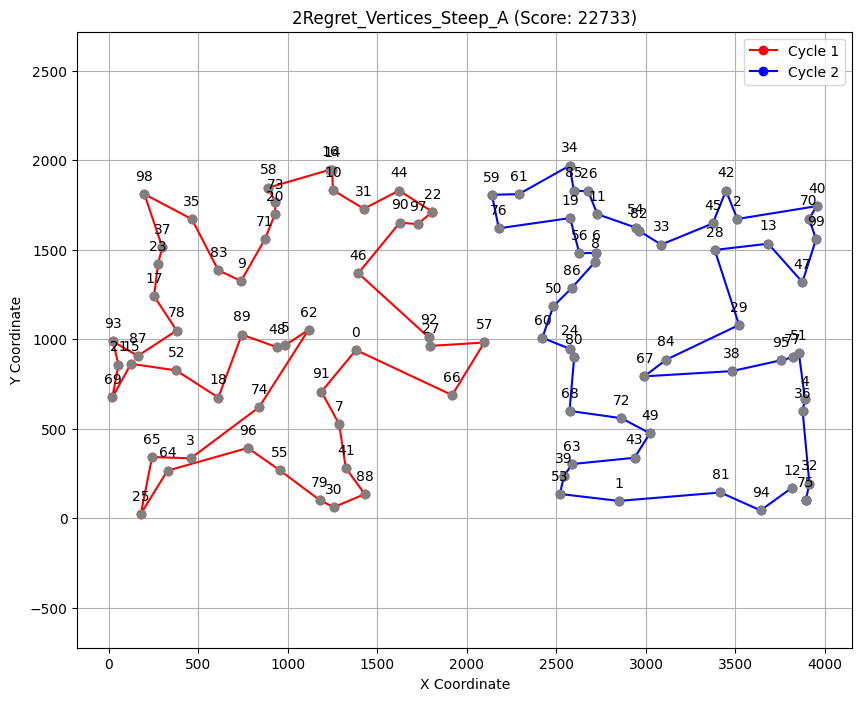

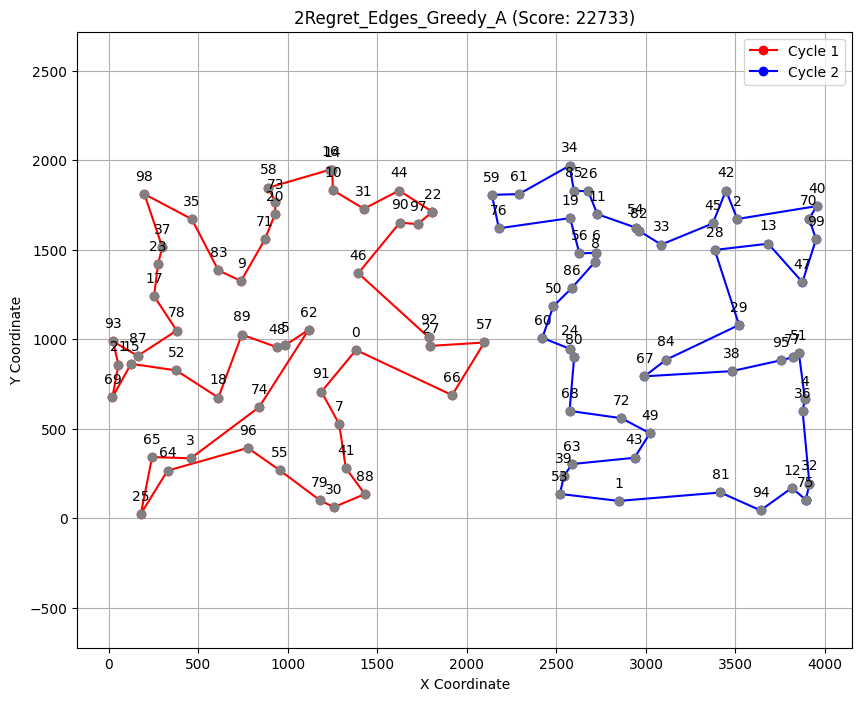

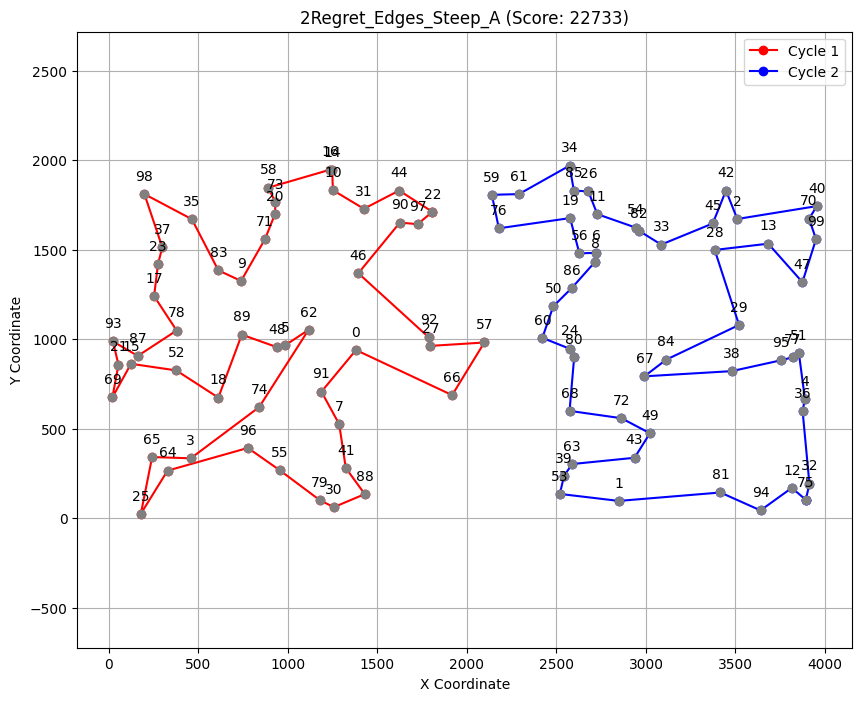

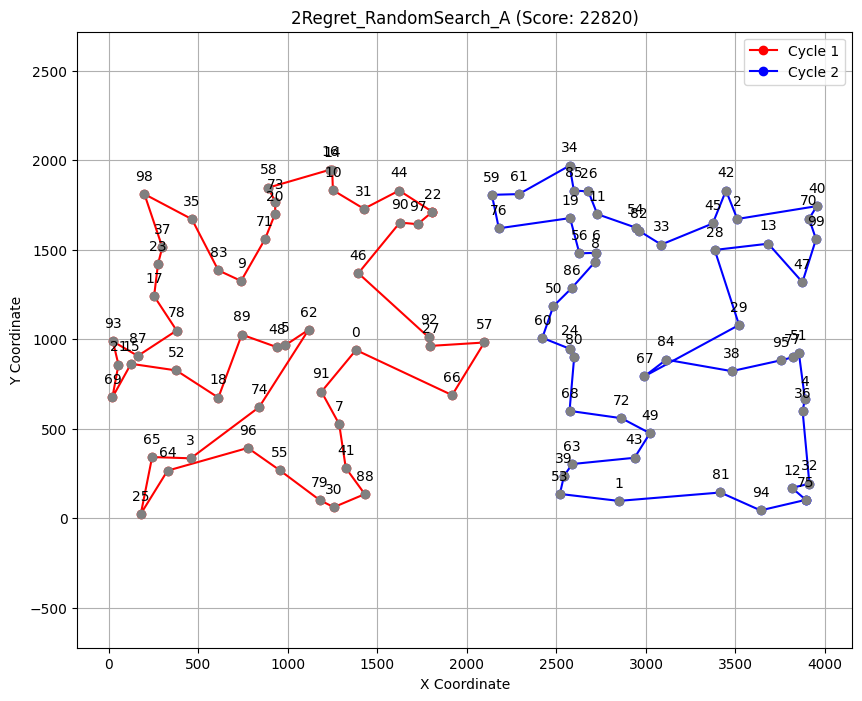

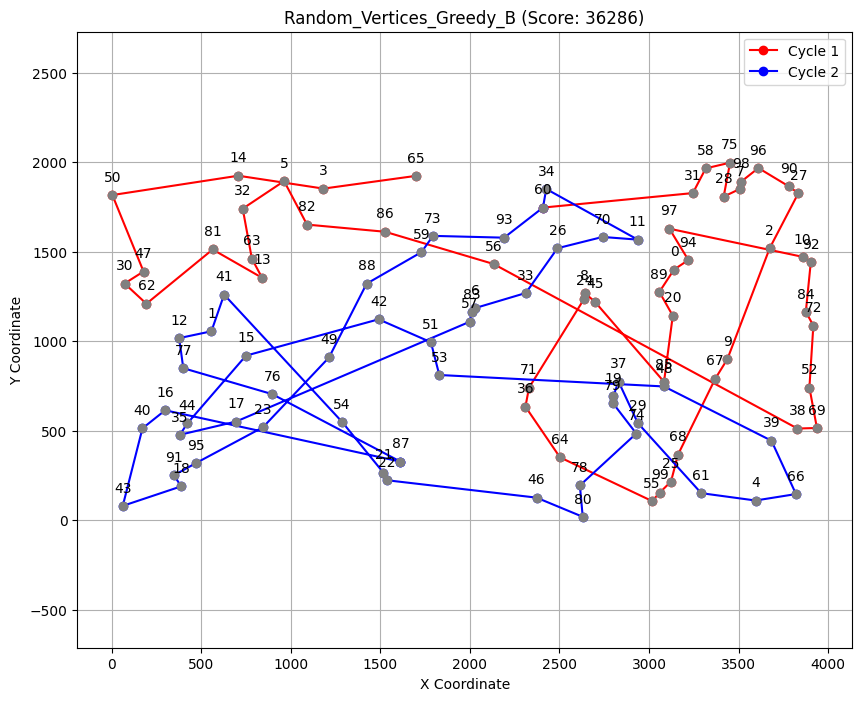

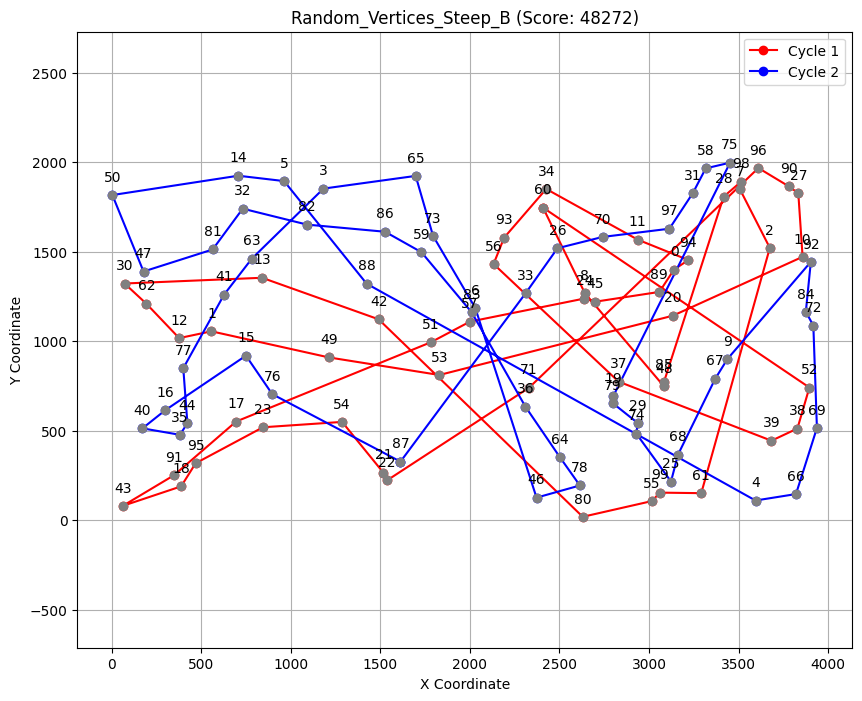

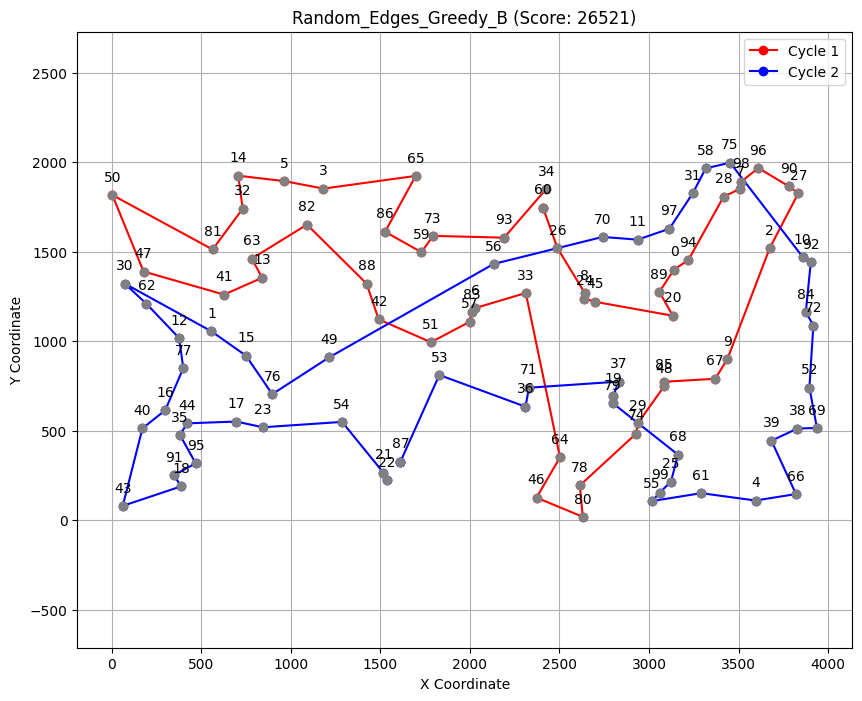

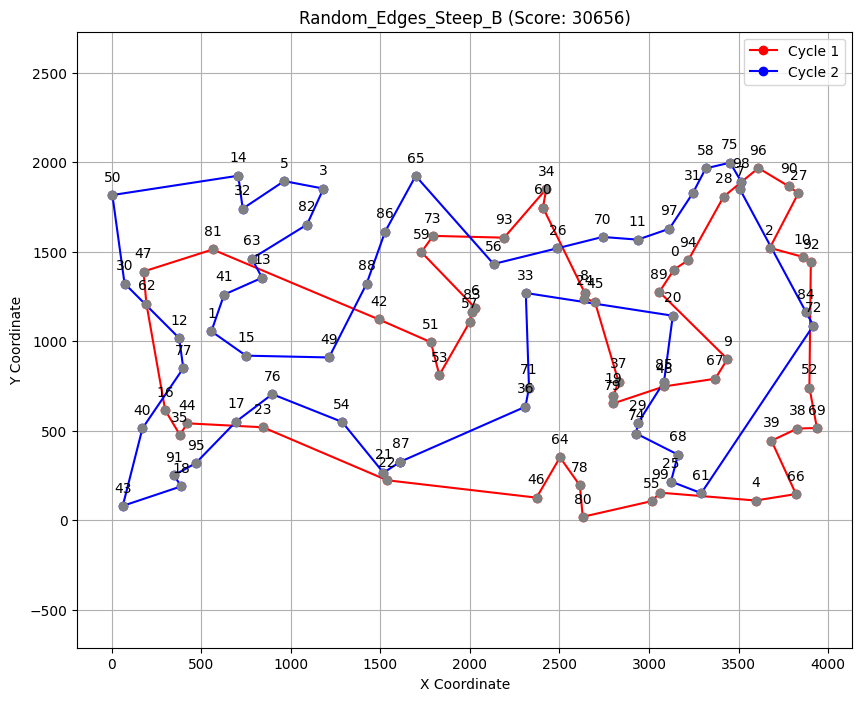

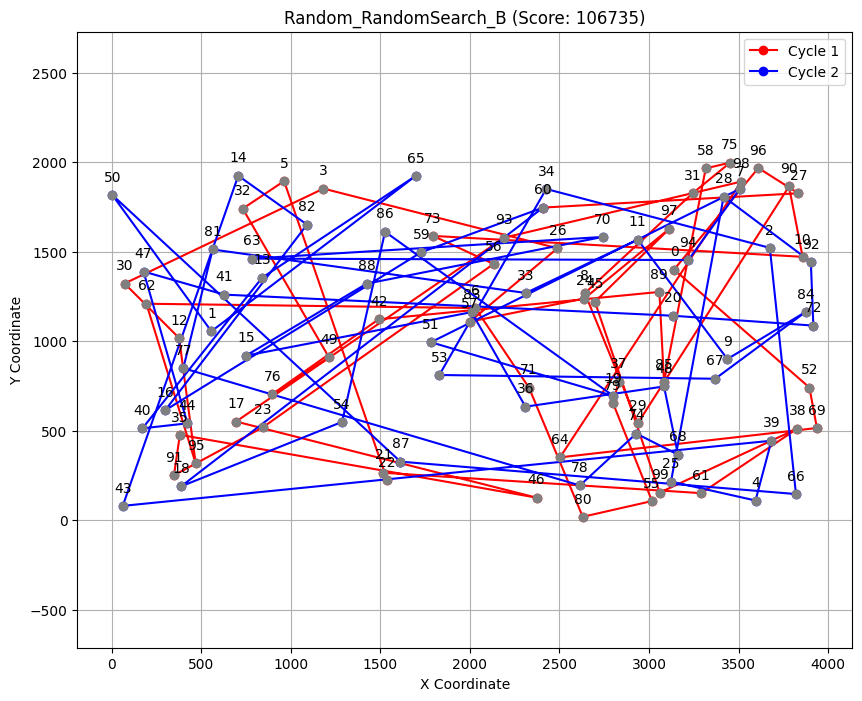

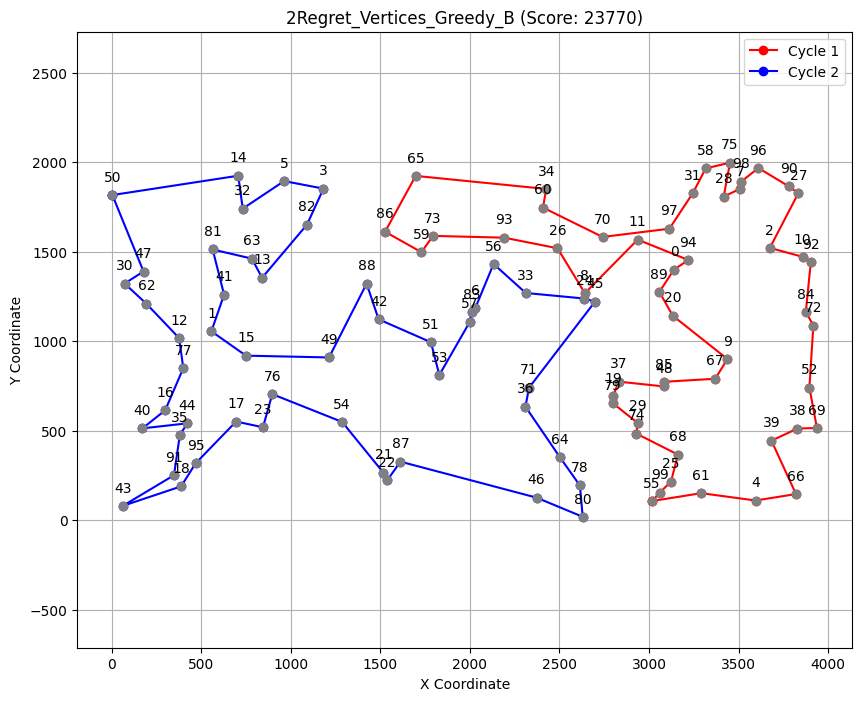

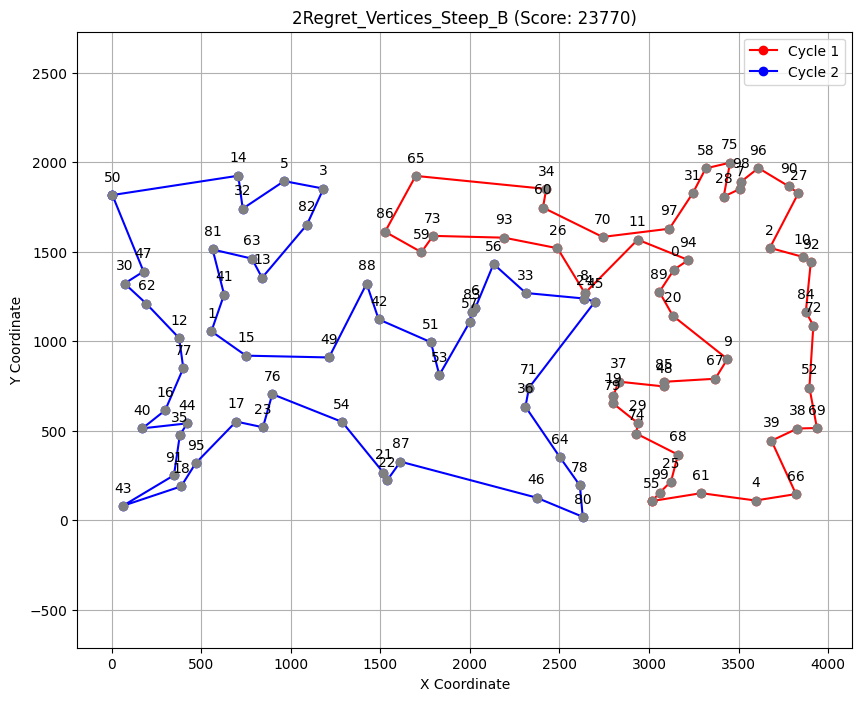

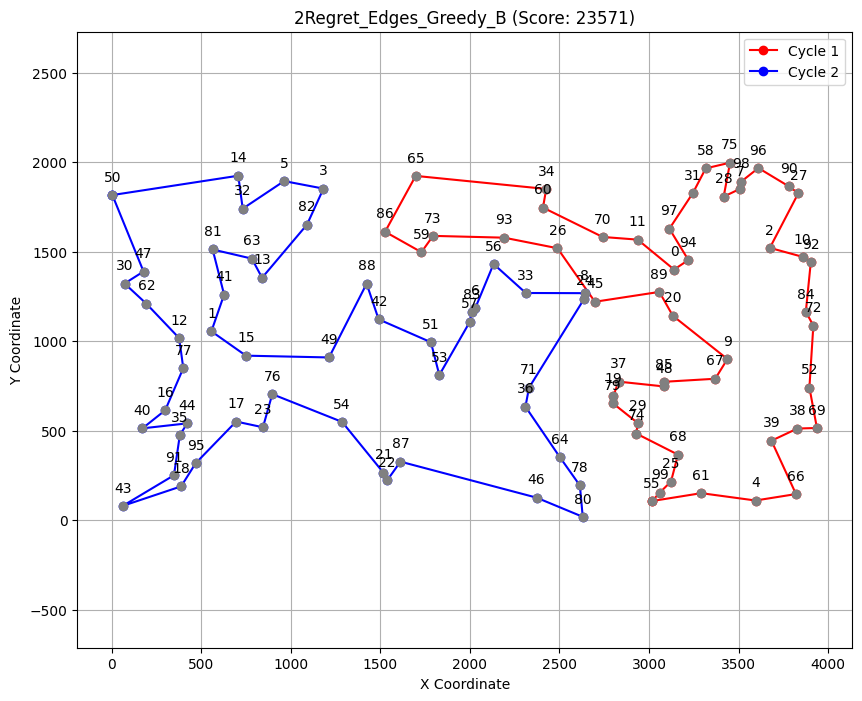

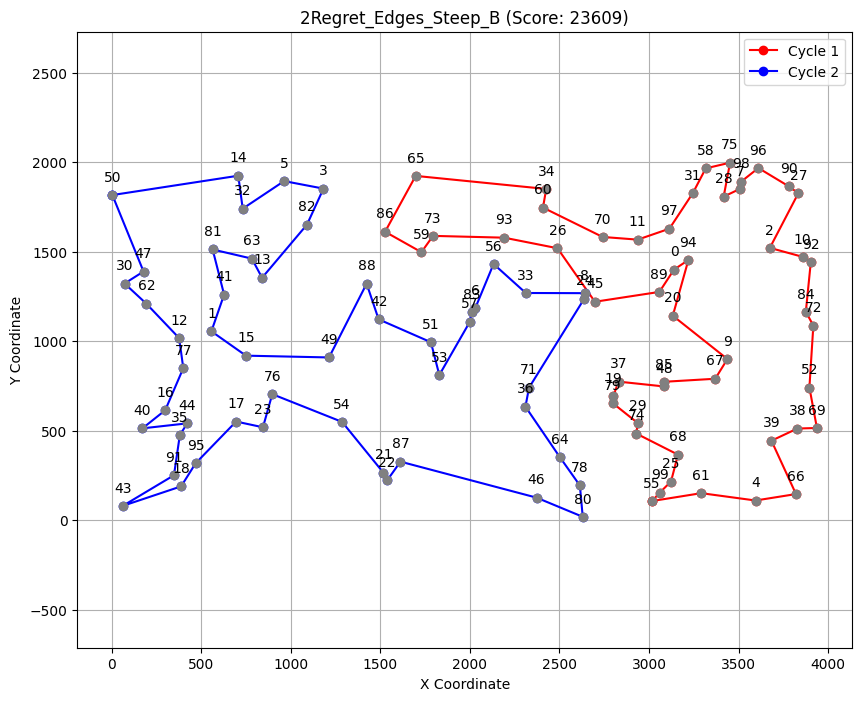

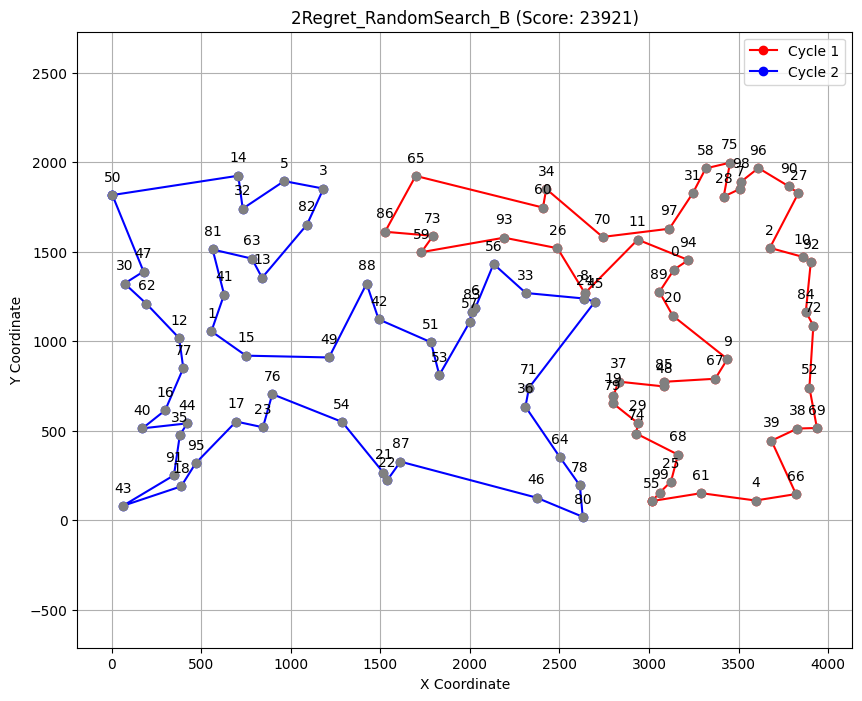

In [11]:
# Plotting best cycles for each combination
for key, value in best_cycles.items():
    best_cycle1, best_cycle2 = value
    if "A" in key:
        score = calculate_score(best_cycle1, best_cycle2, distance_matrix_A)
        plot_cycles(data_kroA100, best_cycle1, best_cycle2, title=f"{key} (Score: {score})")
    elif "B" in key:
        score = calculate_score(best_cycle1, best_cycle2, distance_matrix_B)
        plot_cycles(data_kroB100, best_cycle1, best_cycle2, title=f"{key} (Score: {score})")

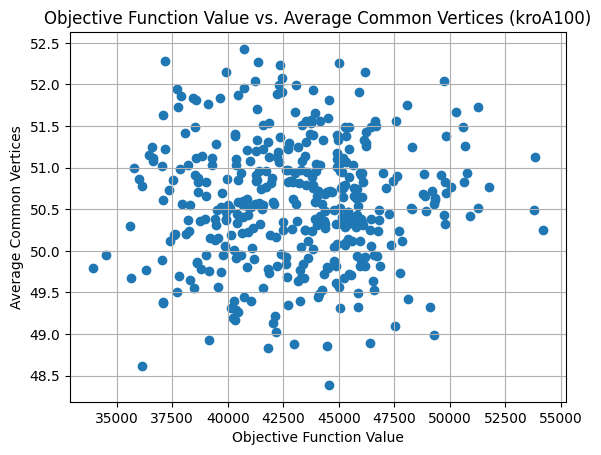

Correlation coefficient (vertices, kroA100): 0.029868755344875278


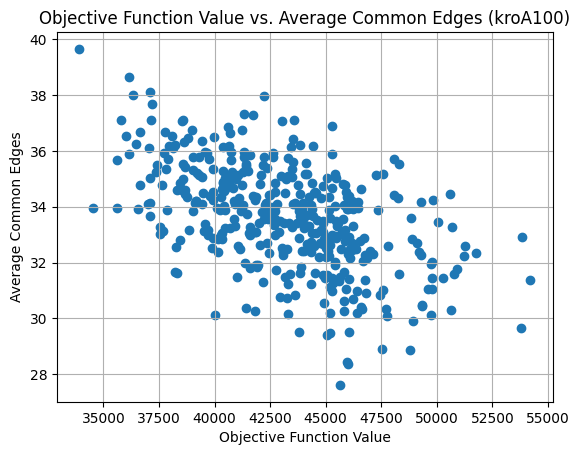

Correlation coefficient (edges, kroA100): -0.5336441570127629


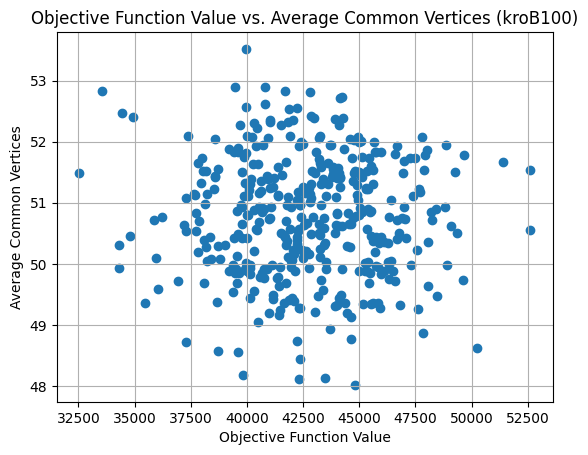

Correlation coefficient (vertices, kroB100): -0.023429519949110102


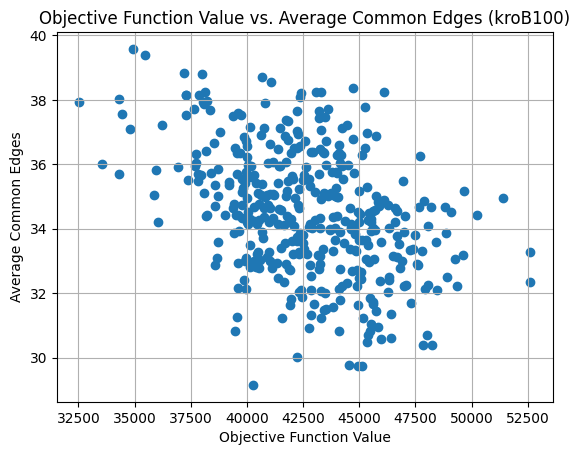

Correlation coefficient (edges, kroB100): -0.4133007624245737


In [5]:
def generate_random_local_optima(num_optima, distance_matrix):
    local_optima = []
    for _ in range(num_optima):
        cycle1, cycle2 = create_random_cycles(distance_matrix)
        best_cycle1, best_cycle2, best_score, _ = greedy_local_search(cycle1, cycle2, distance_matrix, generate_combined_moves_list_1)
        local_optima.append((best_cycle1, best_cycle2, best_score))
    return local_optima

def calculate_common_vertices(cycle1, cycle2, other_cycle1, other_cycle2):
    common_vertices_cycle1 = len(set(cycle1) & set(other_cycle1))
    common_vertices_cycle2 = len(set(cycle2) & set(other_cycle2))
    common_vertices = common_vertices_cycle1 + common_vertices_cycle2
    return common_vertices

def calculate_common_edges(cycle1, cycle2, other_cycle1, other_cycle2):
    def get_edges(cycle):
        return set((min(cycle[i], cycle[i+1]), max(cycle[i], cycle[i+1])) for i in range(len(cycle)-1))

    edges1 = get_edges(cycle1) | get_edges(cycle2)
    edges2 = get_edges(other_cycle1) | get_edges(other_cycle2)
    common_edges = len(edges1 & edges2)
    return common_edges

def calculate_similarities(local_optima, best_solution):
    best_cycle1, best_cycle2, _ = best_solution
    similarities = []
    for cycle1, cycle2, score in local_optima:
        common_vertices = calculate_common_vertices(cycle1, cycle2, best_cycle1, best_cycle2)
        common_edges = calculate_common_edges(cycle1, cycle2, best_cycle1, best_cycle2)
        
        avg_common_vertices = np.mean([calculate_common_vertices(cycle1, cycle2, other_cycle1, other_cycle2)
                                       for other_cycle1, other_cycle2, _ in local_optima])
        avg_common_edges = np.mean([calculate_common_edges(cycle1, cycle2, other_cycle1, other_cycle2)
                                    for other_cycle1, other_cycle2, _ in local_optima])
        
        similarities.append((score, common_vertices, avg_common_vertices, common_edges, avg_common_edges))
    return similarities

def plot_similarity(similarities, measure, instance_name):
    if measure == "vertices":
        x = [s[0] for s in similarities]
        y = [s[2] for s in similarities]
        ylabel = "Average Common Vertices"
    elif measure == "edges":
        x = [s[0] for s in similarities]
        y = [s[4] for s in similarities]
        ylabel = "Average Common Edges"
    
    plt.scatter(x, y)
    plt.xlabel("Objective Function Value")
    plt.ylabel(ylabel)
    plt.title(f"Objective Function Value vs. {ylabel} ({instance_name})")
    plt.grid(True)
    plt.show()

    correlation = np.corrcoef(x, y)[0, 1]
    print(f"Correlation coefficient ({measure}, {instance_name}): {correlation}")

# Running the test
num_optima = 400
local_optima_A = generate_random_local_optima(num_optima, distance_matrix_A)
local_optima_B = generate_random_local_optima(num_optima, distance_matrix_B)

best_solution_A = min(local_optima_A, key=lambda x: x[2])
best_solution_B = min(local_optima_B, key=lambda x: x[2])

similarities_A = calculate_similarities(local_optima_A, best_solution_A)
similarities_B = calculate_similarities(local_optima_B, best_solution_B)

# Plotting and calculating correlation for kroA100
plot_similarity(similarities_A, "vertices", "kroA100")
plot_similarity(similarities_A, "edges", "kroA100")

# Plotting and calculating correlation for kroB100
plot_similarity(similarities_B, "vertices", "kroB100")
plot_similarity(similarities_B, "edges", "kroB100")